# How to transform data into factors

We create the dataset here and store it in our [data](../../data) folder to facilitate reuse in later chapters.

## Imports & Settings

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
%matplotlib inline

import numpy as np
import pandas as pd
import pandas_datareader.data as web

# from pyfinance.ols import PandasRollingOLS

# replaces pyfinance.ols.PandasRollingOLS (no longer maintained)
from statsmodels.regression.rolling import RollingOLS
import statsmodels.api as sm
from talib import RSI, BBANDS, MACD, NATR, ATR

from sklearn.feature_selection import mutual_info_classif, mutual_info_regression

import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
sns.set_style('whitegrid')
idx = pd.IndexSlice

## Load NASDAQ equity OHLCV data

The `assets.h5` store can be generated using the the notebook [create_datasets](../../data/create_datasets.ipynb) in the [data](../../data) directory in the root directory of this repo for instruction to download the following dataset.

We load the Quandl stock price datasets covering the US equity markets 2000-18 using `pd.IndexSlice` to perform a slice operation on the `pd.MultiIndex`, select the adjusted close price and unpivot the column to convert the DataFrame to wide format with tickers in the columns and timestamps in the rows:

Set data store location:

In [5]:
DATA_STORE = './data/assets.h5'

In [6]:
YEAR = 12

In [7]:
START = 1995
END = 2017

In [19]:
with pd.HDFStore(DATA_STORE, 'r') as store:
    prices = (store['quandl/wiki/prices']
              .loc[idx[str(START):str(END), :], :]
              .filter(like='adj_')
              .dropna()
              .swaplevel()
              .rename(columns=lambda x: x.replace('adj_', ''))
              .join(store['us_equities/stocks']
                    .loc[:, ['sector']])
              .dropna())

In [20]:
prices.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 10241831 entries, ('AAN', Timestamp('1995-01-03 00:00:00')) to ('ZUMZ', Timestamp('2017-12-29 00:00:00'))
Data columns (total 6 columns):
 #   Column  Dtype  
---  ------  -----  
 0   open    float64
 1   high    float64
 2   low     float64
 3   close   float64
 4   volume  float64
 5   sector  object 
dtypes: float64(5), object(1)
memory usage: 508.7+ MB


In [21]:
len(prices.index.unique('ticker'))

2369

## Remove stocks with less than ten years of data

In [25]:
min_obs = 10 * 252
nobs = prices.groupby(level='ticker').size()
to_drop = nobs[nobs < min_obs].index
prices = prices.drop(to_drop, level='ticker')

In [26]:
prices.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 9532628 entries, ('AAN', Timestamp('1995-01-03 00:00:00')) to ('ZUMZ', Timestamp('2017-12-29 00:00:00'))
Data columns (total 6 columns):
 #   Column  Dtype  
---  ------  -----  
 0   open    float64
 1   high    float64
 2   low     float64
 3   close   float64
 4   volume  float64
 5   sector  object 
dtypes: float64(5), object(1)
memory usage: 473.5+ MB


In [27]:
len(prices.index.unique('ticker'))

1883

## Add some Basic Factors

### Compute the Relative Strength Index

In [89]:
rsi = prices.groupby(level='ticker').close.apply(RSI)
prices['rsi'] = rsi.values

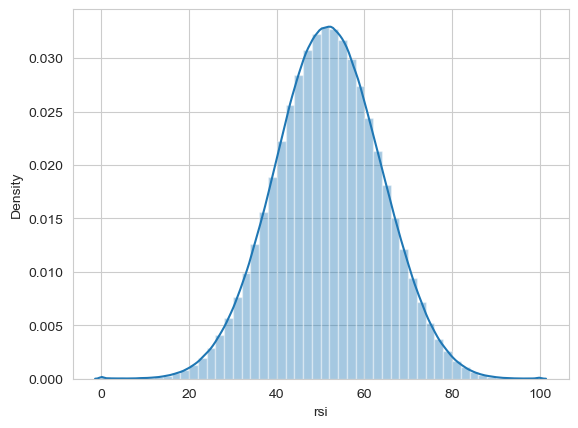

In [90]:
sns.distplot(prices.rsi);

### Compute Bollinger Bands

In [74]:
def compute_bb(close):
    high, mid, low = BBANDS(np.log1p(close), timeperiod=20)
    return pd.DataFrame({'bb_high': high,
                         'bb_mid': mid,
                         'bb_low': low}, index=close.index)

In [117]:
bb = prices.groupby(level='ticker').close.apply(compute_bb)

prices['bb_high'] = bb['bb_high'].values
prices['bb_mid'] = bb['bb_mid'].values
prices['bb_low'] = bb['bb_low'].values


In [118]:
prices.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 9532628 entries, ('AAN', Timestamp('1995-01-03 00:00:00')) to ('ZUMZ', Timestamp('2017-12-29 00:00:00'))
Data columns (total 10 columns):
 #   Column   Dtype  
---  ------   -----  
 0   open     float64
 1   high     float64
 2   low      float64
 3   close    float64
 4   volume   float64
 5   sector   object 
 6   rsi      float64
 7   bb_high  float64
 8   bb_mid   float64
 9   bb_low   float64
dtypes: float64(9), object(1)
memory usage: 764.4+ MB


In [119]:
prices.filter(like='bb_').describe()

,bb_high,bb_mid,bb_low
count,9.496851e+06,9.496851e+06,9.496851e+06
mean,2.954140e+00,2.881157e+00,2.808174e+00
std,1.024536e+00,1.026901e+00,1.032999e+00
min,8.933146e-03,8.933146e-03,-1.568426e+00
25%,2.303724e+00,2.226078e+00,2.146471e+00
50%,2.940911e+00,2.868116e+00,2.796484e+00
75%,3.555602e+00,3.487039e+00,3.420498e+00
max,1.376991e+01,1.358056e+01,1.346225e+01


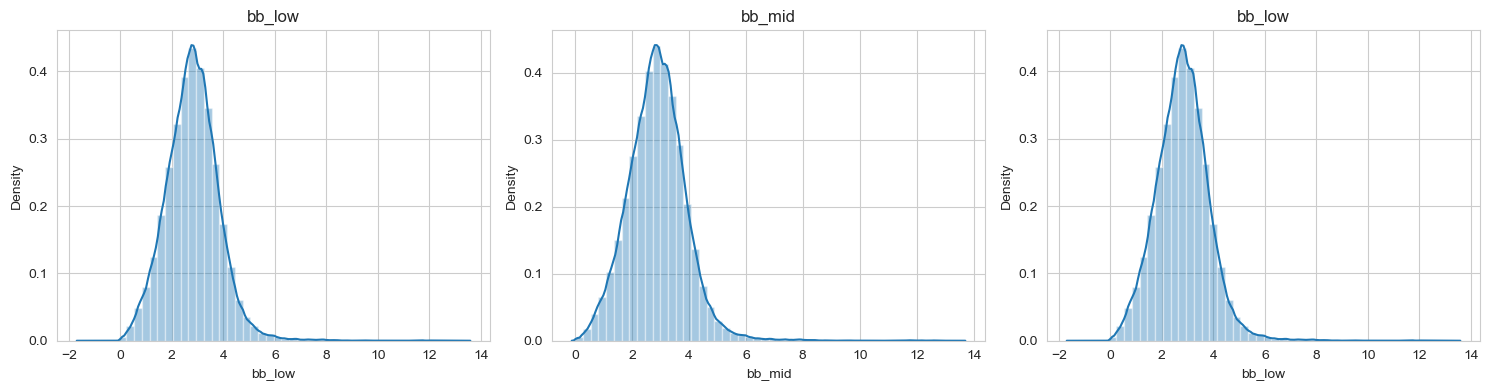

In [120]:
fig, axes = plt.subplots(ncols=3, figsize=(15,4))
for i, col in enumerate(['bb_low', 'bb_mid', 'bb_low']):
    sns.distplot(prices[col], ax=axes[i])
    axes[i].set_title(col);
fig.tight_layout();

In [121]:
prices['bb_up'] = prices.bb_high.sub(np.log1p(prices.close))
prices['bb_down'] = np.log1p(prices.close).sub(prices.bb_low)

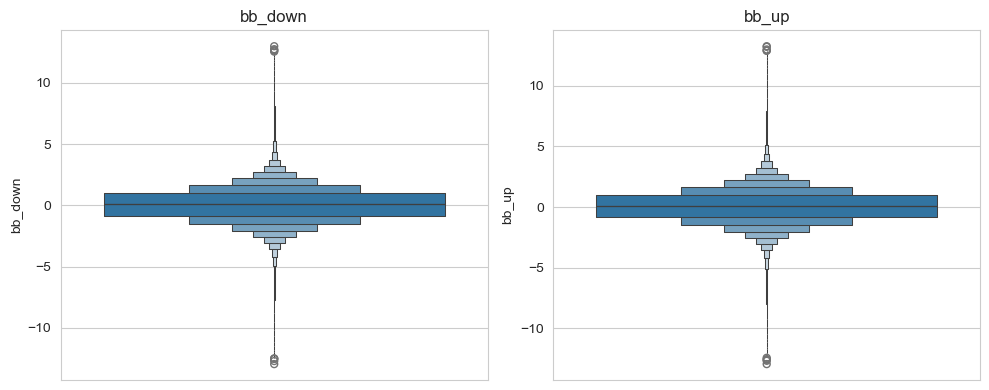

In [122]:
fig, axes = plt.subplots(ncols=2, figsize=(10,4))
for i, col in enumerate(['bb_down', 'bb_up']):
    sns.boxenplot(prices[col], ax=axes[i])
    axes[i].set_title(col);
fig.tight_layout();

### Compute Average True Range

Helper for indicators with multiple inputs:

In [123]:
by_ticker = prices.groupby('ticker', group_keys=False)

In [124]:
def compute_atr(stock_data):
    atr = ATR(stock_data.high, 
              stock_data.low, 
              stock_data.close, 
              timeperiod=14)
    return atr.sub(atr.mean()).div(atr.std())

In [125]:
prices['atr'] = by_ticker.apply(compute_atr)

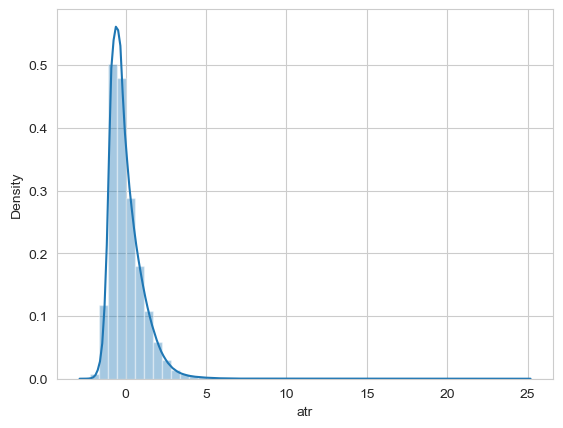

In [126]:
sns.distplot(prices.atr);

In [127]:
prices['natr'] = by_ticker.apply(lambda x: NATR(high=x.high, low=x.low, close=x.close))

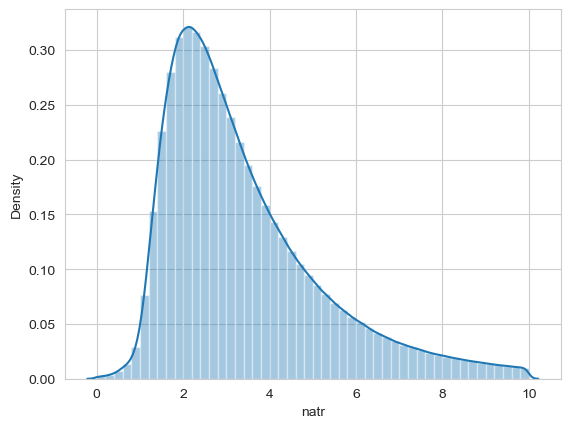

In [128]:
sns.distplot(prices.natr[prices.natr<10]);

### Compute Moving Average Convergence/Divergence

In [130]:
def compute_macd(close):
    macd = MACD(close)[0]
    return macd.sub(macd.mean()).div(macd.std())

prices['macd'] = prices.groupby(level='ticker').close.apply(compute_macd).values

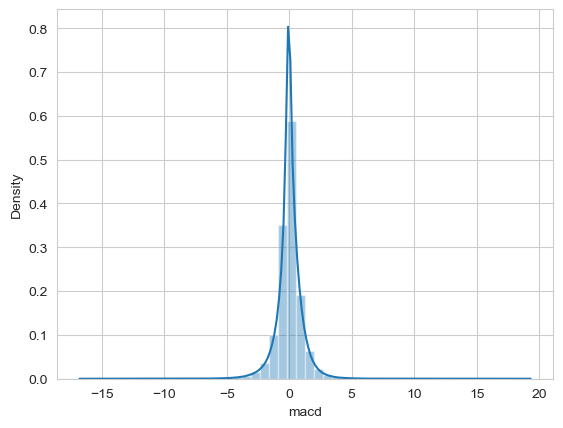

In [131]:
sns.distplot(prices.macd);

## Compute dollar volume to determine universe

In [132]:
prices['dollar_volume'] = (prices.loc[:, 'close']
                           .mul(prices.loc[:, 'volume'], axis=0))

prices.dollar_volume /= 1e6

In [133]:
prices.to_hdf('data.h5', 'us/equities/prices')

In [136]:
prices = pd.read_hdf('data.h5', 'us/equities/prices')
prices.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 9532628 entries, ('AAN', Timestamp('1995-01-03 00:00:00')) to ('ZUMZ', Timestamp('2017-12-29 00:00:00'))
Data columns (total 16 columns):
 #   Column         Dtype  
---  ------         -----  
 0   open           float64
 1   high           float64
 2   low            float64
 3   close          float64
 4   volume         float64
 5   sector         object 
 6   rsi            float64
 7   bb_high        float64
 8   bb_mid         float64
 9   bb_low         float64
 10  bb_up          float64
 11  bb_down        float64
 12  atr            float64
 13  natr           float64
 14  macd           float64
 15  dollar_volume  float64
dtypes: float64(15), object(1)
memory usage: 1.2+ GB


## Resample OHLCV prices to monthly frequency

To reduce training time and experiment with strategies for longer time horizons, we convert the business-daily data to month-end frequency using the available adjusted close price:

In [137]:
last_cols = [c for c in prices.columns.unique(0) if c not in ['dollar_volume', 'volume',
                                                              'open', 'high', 'low']]

In [138]:
prices = prices.unstack('ticker')

In [139]:
data = (pd.concat([prices.dollar_volume.resample('M').mean().stack('ticker').to_frame('dollar_volume'),
                   prices[last_cols].resample('M').last().stack('ticker')],
                  axis=1)
        .swaplevel()
        .dropna())

In [140]:
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 454326 entries, ('AAN', Timestamp('1995-01-31 00:00:00')) to ('ORN', Timestamp('2017-12-31 00:00:00'))
Data columns (total 12 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   dollar_volume  454326 non-null  float64
 1   atr            454326 non-null  float64
 2   bb_down        454326 non-null  float64
 3   bb_high        454326 non-null  float64
 4   bb_low         454326 non-null  float64
 5   bb_mid         454326 non-null  float64
 6   bb_up          454326 non-null  float64
 7   close          454326 non-null  float64
 8   macd           454326 non-null  float64
 9   natr           454326 non-null  float64
 10  rsi            454326 non-null  float64
 11  sector         454326 non-null  object 
dtypes: float64(11), object(1)
memory usage: 43.4+ MB


## Select 500 most-traded equities

Select the 500 most-traded stocks based on a 5-year rolling average of dollar volume.

In [141]:
data['dollar_volume'] = (data.loc[:, 'dollar_volume']
                         .unstack('ticker')
                         .rolling(window=5*12, min_periods=12)
                         .mean()
                         .stack()
                         .swaplevel())

In [142]:
data['dollar_vol_rank'] = (data
                           .groupby('date')
                           .dollar_volume
                           .rank(ascending=False))

data = data[data.dollar_vol_rank < 500].drop(['dollar_volume', 'dollar_vol_rank'], axis=1)

In [143]:
len(data.index.unique('ticker'))

918

## Create monthly return series

To capture time series dynamics that reflect, for example, momentum patterns, we compute historical returns using the method `.pct_change(n_periods)`, that is, returns over various monthly periods as identified by lags.

We then convert the wide result back to long format with the `.stack()` method, use `.pipe()` to apply the `.clip()` method to the resulting `DataFrame`, and winsorize returns at the [1%, 99%] levels; that is, we cap outliers at these percentiles.

Finally, we normalize returns using the geometric average. After using `.swaplevel()` to change the order of the `MultiIndex` levels, we obtain compounded monthly returns for six periods ranging from 1 to 12 months:

In [150]:
outlier_cutoff = 0.01
lags = [1, 3, 6, 12]
returns = []

In [151]:
for lag in lags:
    returns.append(data
                   .close
                   .unstack('ticker')
                   .sort_index()
                   .pct_change(lag)
                   .stack('ticker')
                   .pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff),
                                          upper=x.quantile(1-outlier_cutoff)))
                   .add(1)
                   .pow(1/lag)
                   .sub(1)
                   .to_frame(f'return_{lag}m')
                   )
    
returns = pd.concat(returns, axis=1).swaplevel()
returns.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 206293 entries, ('AAPL', Timestamp('1996-01-31 00:00:00')) to ('DXCM', Timestamp('2017-12-31 00:00:00'))
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   return_1m   206293 non-null  float64
 1   return_3m   204457 non-null  float64
 2   return_6m   201711 non-null  float64
 3   return_12m  196243 non-null  float64
dtypes: float64(4)
memory usage: 7.1+ MB


In [152]:
returns.describe()

,return_1m,return_3m,return_6m,return_12m
count,206293.000000,204457.000000,201711.000000,196243.000000
mean,0.007240,0.004894,0.004301,0.004139
std,0.085485,0.050658,0.037003,0.027123
min,-0.272889,-0.179022,-0.133999,-0.093584
25%,-0.010699,-0.002568,-0.000039,0.000000
50%,0.000000,0.000000,0.000000,0.000000
75%,0.031914,0.023190,0.018536,0.015181
max,0.331039,0.180229,0.131033,0.100088


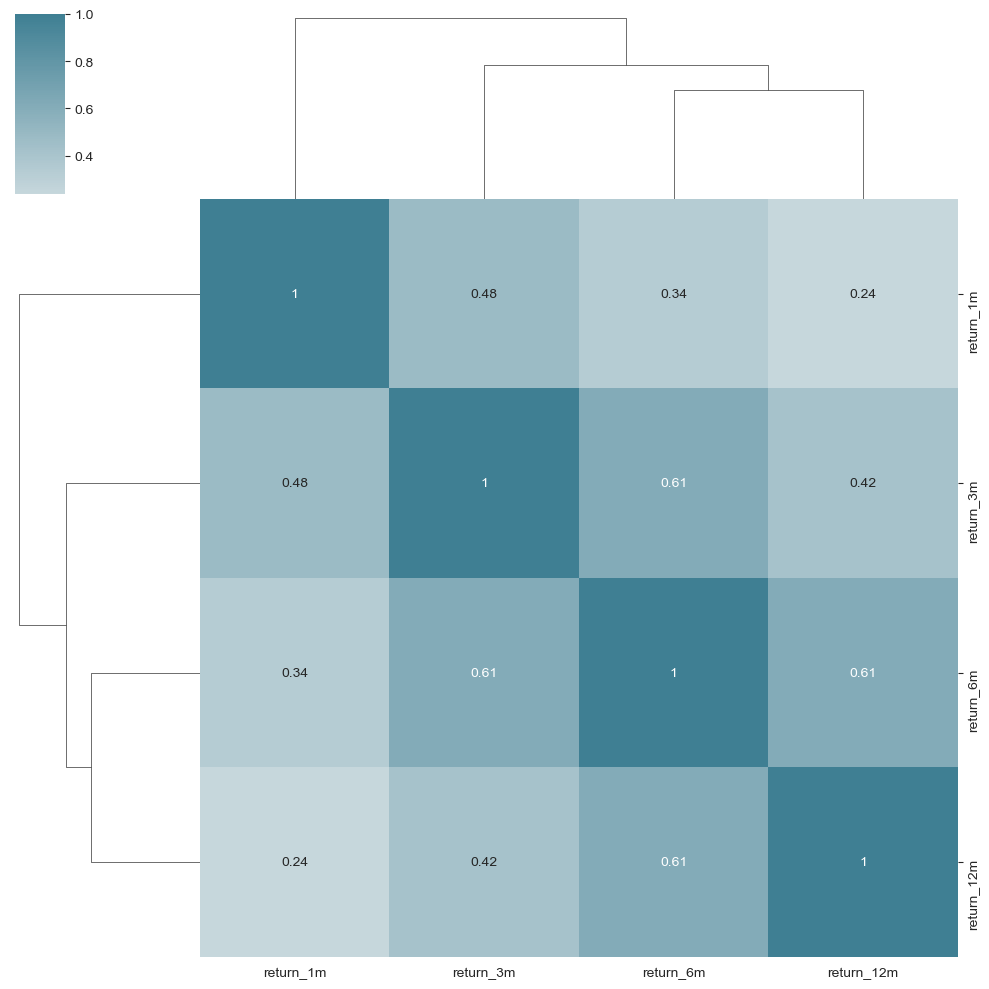

In [155]:
cmap = sns.diverging_palette(10, 220, as_cmap=True)
sns.clustermap(returns.corr('spearman'), annot=True, center=0, cmap=cmap);

In [163]:
data = data.join(returns).drop('close', axis=1).dropna()
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 115627 entries, ('AAPL', Timestamp('1996-12-31 00:00:00')) to ('VMW', Timestamp('2017-12-31 00:00:00'))
Data columns (total 14 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   atr         115627 non-null  float64
 1   bb_down     115627 non-null  float64
 2   bb_high     115627 non-null  float64
 3   bb_low      115627 non-null  float64
 4   bb_mid      115627 non-null  float64
 5   bb_up       115627 non-null  float64
 6   macd        115627 non-null  float64
 7   natr        115627 non-null  float64
 8   rsi         115627 non-null  float64
 9   sector      115627 non-null  object 
 10  return_1m   115627 non-null  float64
 11  return_3m   115627 non-null  float64
 12  return_6m   115627 non-null  float64
 13  return_12m  115627 non-null  float64
dtypes: float64(13), object(1)
memory usage: 12.9+ MB


In [161]:
min_obs = 5*12
nobs = data.groupby(level='ticker').size()
to_drop = nobs[nobs < min_obs].index
data = data.drop(to_drop, level='ticker')

In [164]:
tickers_left = len(data.index.unique('ticker'))
f"the result is {tickers_left} tickers"

'the result is 614 tickers'

## Rolling Factor Betas

We will introduce the Fama—French data to estimate the exposure of assets to common risk factors using linear regression in [Chapter 8, Time Series Models]([](../../08_time_series_models)).

The five Fama—French factors, namely market risk, size, value, operating profitability, and investment have been shown empirically to explain asset returns and are commonly used to assess the risk/return profile of portfolios. Hence, it is natural to include past factor exposures as financial features in models that aim to predict future returns.

We can access the historical factor returns using the `pandas-datareader` and estimate historical exposures using the `PandasRollingOLS` rolling linear regression functionality in the `pyfinance` library as follows:

Use Fama-French research factors to estimate the factor exposures of the stock in the dataset to the 5 factors market risk, size, value, operating profitability and investment.

In [165]:
factors = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']
factor_data = web.DataReader('F-F_Research_Data_5_Factors_2x3', 
                             'famafrench', 
                             start=START)[0].drop('RF', axis=1)
factor_data.index = factor_data.index.to_timestamp()
factor_data = factor_data.resample('M').last().div(100)
factor_data.index.name = 'date'
factor_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 351 entries, 1995-01-31 to 2024-03-31
Freq: M
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Mkt-RF  351 non-null    float64
 1   SMB     351 non-null    float64
 2   HML     351 non-null    float64
 3   RMW     351 non-null    float64
 4   CMA     351 non-null    float64
dtypes: float64(5)
memory usage: 16.5 KB


In [166]:
factor_data = factor_data.join(data['return_1m']).dropna().sort_index()
factor_data['return_1m'] -= factor_data['Mkt-RF']
factor_data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 115627 entries, ('A', Timestamp('2001-11-30 00:00:00')) to ('ZION', Timestamp('2017-12-31 00:00:00'))
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   Mkt-RF     115627 non-null  float64
 1   SMB        115627 non-null  float64
 2   HML        115627 non-null  float64
 3   RMW        115627 non-null  float64
 4   CMA        115627 non-null  float64
 5   return_1m  115627 non-null  float64
dtypes: float64(6)
memory usage: 5.8+ MB


In [167]:
factor_data.describe()

,Mkt-RF,SMB,HML,RMW,CMA,return_1m
count,115627.000000,115627.000000,115627.000000,115627.000000,115627.000000,115627.000000
mean,0.006129,0.002420,0.001888,0.003261,0.002486,0.005435
std,0.044231,0.031599,0.031249,0.029261,0.020979,0.092458
min,-0.172300,-0.153200,-0.112900,-0.186500,-0.068000,-0.386389
25%,-0.019700,-0.016900,-0.014800,-0.010900,-0.010200,-0.043896
50%,0.011700,0.001500,0.000300,0.003700,0.000000,0.002563
75%,0.034900,0.023300,0.016300,0.014000,0.014300,0.050639
max,0.113500,0.182800,0.124700,0.130700,0.090700,0.503339


In [168]:
T = 60
# betas = (factor_data
#          .groupby(level='ticker', group_keys=False)
#          .apply(lambda x: PandasRollingOLS(window=min(T, x.shape[0]-1), 
#                                            y=x.return_1m, 
#                                            x=x.drop('return_1m', axis=1)).beta)
#         .rename(columns={'Mkt-RF': 'beta'}))
betas = (factor_data.groupby(level='ticker',
                             group_keys=False)
         .apply(lambda x: RollingOLS(endog=x.return_1m,
                                     exog=sm.add_constant(x.drop('return_1m', axis=1)),
                                     window=min(T, x.shape[0]-1))
                .fit(params_only=True)
                .params
                .rename(columns={'Mkt-RF': 'beta'})
                .drop('const', axis=1)))

In [169]:
betas.describe().join(betas.sum(1).describe().to_frame('total'))

,beta,SMB,HML,RMW,CMA,total
count,79403.000000,79403.000000,79403.000000,79403.000000,79403.000000,115627.000000
mean,0.066754,0.189508,0.118151,-0.016878,0.009201,0.251844
std,0.479949,0.585485,0.819382,0.879148,0.968658,1.385349
min,-1.841746,-1.994352,-4.038752,-5.185800,-5.124032,-10.019042
25%,-0.256659,-0.204889,-0.414061,-0.492754,-0.541885,-0.139983
50%,0.044331,0.149145,0.062921,0.045939,0.057642,0.000000
75%,0.370557,0.544285,0.605841,0.537322,0.601090,0.843714
max,2.736241,3.290490,4.762842,4.028898,5.070538,10.777134


In [170]:
betas.describe().join(betas.sum(1).describe().to_frame('total'))

,beta,SMB,HML,RMW,CMA,total
count,79403.000000,79403.000000,79403.000000,79403.000000,79403.000000,115627.000000
mean,0.066754,0.189508,0.118151,-0.016878,0.009201,0.251844
std,0.479949,0.585485,0.819382,0.879148,0.968658,1.385349
min,-1.841746,-1.994352,-4.038752,-5.185800,-5.124032,-10.019042
25%,-0.256659,-0.204889,-0.414061,-0.492754,-0.541885,-0.139983
50%,0.044331,0.149145,0.062921,0.045939,0.057642,0.000000
75%,0.370557,0.544285,0.605841,0.537322,0.601090,0.843714
max,2.736241,3.290490,4.762842,4.028898,5.070538,10.777134


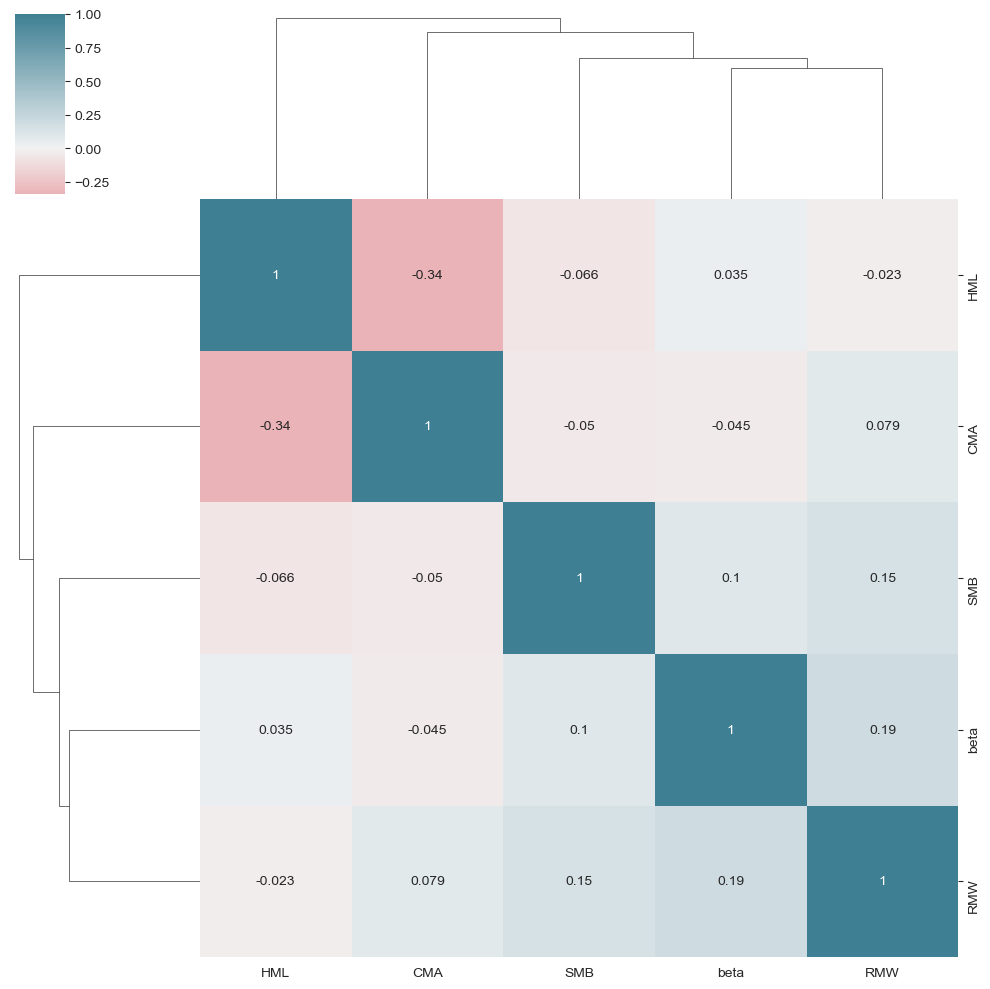

In [171]:
cmap = sns.diverging_palette(10, 220, as_cmap=True)
sns.clustermap(betas.corr(), annot=True, cmap=cmap, center=0);

In [172]:
data = (data
      .join(betas
          .groupby(level='ticker')
          .shift())
     .dropna()
     .sort_index())

In [173]:
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 78789 entries, ('A', Timestamp('2006-11-30 00:00:00')) to ('ZION', Timestamp('2017-12-31 00:00:00'))
Data columns (total 19 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   atr         78789 non-null  float64
 1   bb_down     78789 non-null  float64
 2   bb_high     78789 non-null  float64
 3   bb_low      78789 non-null  float64
 4   bb_mid      78789 non-null  float64
 5   bb_up       78789 non-null  float64
 6   macd        78789 non-null  float64
 7   natr        78789 non-null  float64
 8   rsi         78789 non-null  float64
 9   sector      78789 non-null  object 
 10  return_1m   78789 non-null  float64
 11  return_3m   78789 non-null  float64
 12  return_6m   78789 non-null  float64
 13  return_12m  78789 non-null  float64
 14  beta        78789 non-null  float64
 15  SMB         78789 non-null  float64
 16  HML         78789 non-null  float64
 17  RMW         78789 non-null  floa

## Momentum factors

We can use these results to compute momentum factors based on the difference between returns over longer periods and the most recent monthly return, as well as for the difference between 3 and 12 month returns as follows:

In [174]:
for lag in [3, 6, 12]:
    data[f'momentum_{lag}'] = data[f'return_{lag}m'].sub(data.return_1m)
    if lag > 3:
        data[f'momentum_3_{lag}'] = data[f'return_{lag}m'].sub(data.return_3m)    

## Date Indicators

In [175]:
dates = data.index.get_level_values('date')
data['year'] = dates.year
data['month'] = dates.month

## Target: Holding Period Returns

To compute returns for our one-month target holding period, we use the returns computed previously and shift them back to align them with the current financial features.

In [176]:
data['target'] = data.groupby(level='ticker')[f'return_1m'].shift(-1)

In [177]:
data = data.dropna()

In [179]:
data.sort_index().info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 78175 entries, ('A', Timestamp('2006-11-30 00:00:00')) to ('ZION', Timestamp('2017-11-30 00:00:00'))
Data columns (total 27 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   atr            78175 non-null  float64
 1   bb_down        78175 non-null  float64
 2   bb_high        78175 non-null  float64
 3   bb_low         78175 non-null  float64
 4   bb_mid         78175 non-null  float64
 5   bb_up          78175 non-null  float64
 6   macd           78175 non-null  float64
 7   natr           78175 non-null  float64
 8   rsi            78175 non-null  float64
 9   sector         78175 non-null  object 
 10  return_1m      78175 non-null  float64
 11  return_3m      78175 non-null  float64
 12  return_6m      78175 non-null  float64
 13  return_12m     78175 non-null  float64
 14  beta           78175 non-null  float64
 15  SMB            78175 non-null  float64
 16  HML            7817

## Sector Breakdown

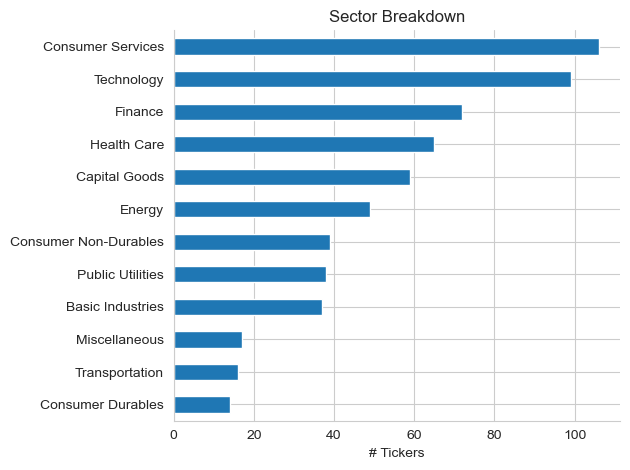

In [180]:
ax = data.reset_index().groupby('sector').ticker.nunique().sort_values().plot.barh(title='Sector Breakdown')
ax.set_ylabel('')
ax.set_xlabel('# Tickers')
sns.despine()
plt.tight_layout();

## Store data

In [181]:
with pd.HDFStore('data.h5') as store:
    store.put('us/equities/monthly', data)

## Evaluate mutual information

In [182]:
X = data.drop('target', axis=1)
X.sector = pd.factorize(X.sector)[0]

In [183]:
mi = mutual_info_regression(X=X, y=data.target)

In [184]:
mi_reg = pd.Series(mi, index=X.columns)
mi_reg.nlargest(10)

natr             0.111602
return_12m       0.059736
return_6m        0.053566
year             0.049769
return_3m        0.046735
momentum_3_12    0.039842
momentum_3_6     0.037955
return_1m        0.034780
momentum_12      0.034742
momentum_6       0.034396
dtype: float64

In [185]:
mi = mutual_info_classif(X=X, y=(data.target>0).astype(int))

In [186]:
mi_class = pd.Series(mi, index=X.columns)
mi_class.nlargest(10)

month         0.010064
year          0.008204
atr           0.005111
return_6m     0.005028
bb_high       0.004898
bb_up         0.003892
return_12m    0.002645
HML           0.002144
return_1m     0.002138
natr          0.001922
dtype: float64

In [187]:
mi = mi_reg.to_frame('Regression').join(mi_class.to_frame('Classification'))

In [188]:
mi.index = [' '.join(c.upper().split('_')) for c in mi.index]

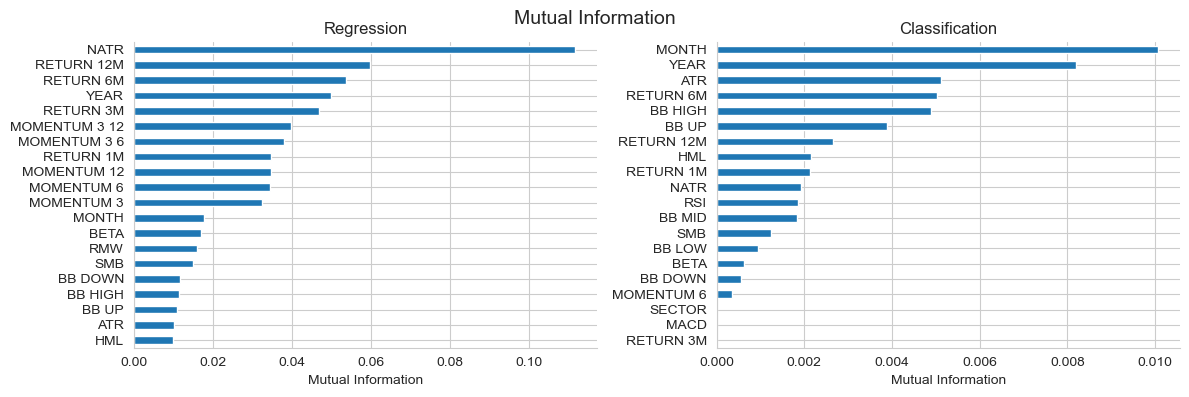

In [189]:
fig, axes = plt.subplots(ncols=2, figsize=(12, 4))
for i, t in enumerate(['Regression', 'Classification']):
    mi[t].nlargest(20).sort_values().plot.barh(title=t, ax=axes[i])
    axes[i].set_xlabel('Mutual Information')
fig.suptitle('Mutual Information', fontsize=14)
sns.despine()
fig.tight_layout()
fig.subplots_adjust(top=.9)